<center><h1>Introduction to Equistore</h1></center>

This document present [equistore](https://github.com/lab-cosmo/equistore), a
format for data exchange between atomistic machine learning software. We will go
over the basics of this format, and how one can exploit the metadata to simplify
building complex models.

You can install all the dependency used in this tutorial with pip:

```
pip install -r requirements.txt
```

# Exploring an equivariant representation: the spherical expansion

One of the simplest equivariant representation is the SOAP spherical expansion. It is built by representing atoms as multiple atomic density (one per species $\alpha$) $\braket{r|\rho_i^\alpha}$, and then expanding this density on a set of radial and angular basis functions: $\braket{n l m |\rho_i^\alpha}$. 

See the ["Efficient implementation of atom-density representations"](https://aip.scitation.org/doi/10.1063/5.0044689) article or the ["Physics-Inspired Structural Representations for Molecules and Materials"](https://pubs.acs.org/doi/10.1021/acs.chemrev.1c00021) review for more information on the
spherical expansion and SOAP.

In this tutorial, we will use [rascaline](https://github.com/Luthaf/rascaline/)
to compute the spherical expansion. Rascaline is a prototype library to compute
SOAP and related representations directly using the equistore format, but is not
required at all when using equistore!

On the contrary, one of the explicit goal of equistore is to be useable as a
standalone tool, and integrate well with different libraries.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

import rascaline
import equistore
import equistore.io

import ase.io

We will use a small dataset of water molecules, containing information about the energy and forces of each structure

In [47]:
structures = ase.io.read("data/water-dipoles.xyz", ":10")

Let's use rascaline to compute the spherical expansion, and get the
representation of all these structures

In [75]:
# see https://luthaf.fr/rascaline/ for the documentation of rascaline
calculator = rascaline.SphericalExpansion(
    cutoff=3.0, 
    max_radial=5, 
    max_angular=6, 
    atomic_gaussian_width=0.3, 
    radial_basis={"Gto": {}}, 
    center_atom_weight=1.0, 
    gradients=True, 
    cutoff_function={"ShiftedCosine": {"width": 0.5}}
)

representation = calculator.compute(structures)

`representation` is now a TensorMap, the core object in equistore

In [49]:
representation

TensorMap with 28 blocks
keys: ['spherical_harmonics_l' 'species_center' 'species_neighbor']
                  0                   1                1
                  1                   1                1
                  2                   1                1
               ...
                  4                   8                8
                  5                   8                8
                  6                   8                8

A TensorMap is similar to a dictionary: it contains multiple keys, and a block of data is associated with each key

In [50]:
representation.keys

Labels([(0, 1, 1), (1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1),
        (6, 1, 1), (0, 1, 8), (1, 1, 8), (2, 1, 8), (3, 1, 8), (4, 1, 8),
        (5, 1, 8), (6, 1, 8), (0, 8, 1), (1, 8, 1), (2, 8, 1), (3, 8, 1),
        (4, 8, 1), (5, 8, 1), (6, 8, 1), (0, 8, 8), (1, 8, 8), (2, 8, 8),
        (3, 8, 8), (4, 8, 8), (5, 8, 8), (6, 8, 8)],
       dtype=[('spherical_harmonics_l', '<i4'), ('species_center', '<i4'), ('species_neighbor', '<i4')])

The keys (like all metadata in equistore) are represented as a set of `Labels`.

A `Labels` instance contains multiple entries, each entry containing multiple variables. 
The variables names define what is being represented. 

Here, we have three variables in the keys: `species_center` and
`species_neighbor` define the species of the central atom (the spherical
expansion is an atom-centered representation) and neighbor atomic density. These
two variables are used to exploit the inherent sparsity of atom-density
representations.

`spherical_harmonics_l` defines which set of spherical harmonics is being used
in the corresponding data block, carrying information about the equivariance of
the representation.

In [51]:
print(representation.keys.names)

('spherical_harmonics_l', 'species_center', 'species_neighbor')


In [52]:
# two different entries in the keys, corresponding to two different blocks
print(representation.keys[0])
print(representation.keys[18])

(0, 1, 1)
(4, 8, 1)


One can also access `Labels` one (or multiple) variable at the time, which is useful when transforming the data

In [53]:
print("spherical_harmonics_l =", representation.keys["spherical_harmonics_l"])
print("\n\nspecies =", representation.keys[["species_center", "species_neighbor"]])

spherical_harmonics_l = [0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6]


species = [(1, 1) (1, 1) (1, 1) (1, 1) (1, 1) (1, 1) (1, 1) (1, 8) (1, 8) (1, 8)
 (1, 8) (1, 8) (1, 8) (1, 8) (8, 1) (8, 1) (8, 1) (8, 1) (8, 1) (8, 1)
 (8, 1) (8, 8) (8, 8) (8, 8) (8, 8) (8, 8) (8, 8) (8, 8)]


We can get the blocks associated with a given key (or set of keys) in multiple
ways. The most basic is to get the block by the index of the associated key:

In [54]:
block = representation.block(18)
block

TensorBlock 
samples: ['structure', 'center']
component: ['spherical_harmonics_m']
properties: ['n']
gradients: ['positions']

Alternatively, one can get a block by explicitly selecting some of the key variables:

In [55]:
block = representation.block(spherical_harmonics_l=3, species_center=8, species_neighbor=1)
block

TensorBlock 
samples: ['structure', 'center']
component: ['spherical_harmonics_m']
properties: ['n']
gradients: ['positions']

And even get multiple blocks by only giving a subset of the variables:

In [56]:
blocks = representation.block(spherical_harmonics_l=3)

print(type(blocks), "containing", len(blocks), "blocks")

<class 'list'> containing 4 blocks


Blocks as represented by the `TensorBlock` class. Each block contains a main set
of values (the representation itself), metadata associated with these values, and 
optionally gradients of the values with respect to multiple parameters.

In [76]:
block = representation.block(spherical_harmonics_l=3, species_center=1, species_neighbor=8)

print(block.values.dtype)
print(block.values.shape)

# uncomment this to see the raw representation
# print(block.values)

float64
(20, 7, 5)


The values are stored in an n-dimensional array, with at least 2 dimensions. The
first dimension correspond to the **samples** (also sometimes called inputs or
batches), i.e. **what** is being represented. 

The samples are describe by a set of `Labels`, with one entry in the labels for
each row of the array. 

For the spherical expansion, the samples contain information about which atom in
which structure each row corresponds to.

In [58]:
block.samples

Labels([(0, 1), (0, 2), (1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2),
        (4, 1), (4, 2), (5, 1), (5, 2), (6, 1), (6, 2), (7, 1), (7, 2),
        (8, 1), (8, 2), (9, 1), (9, 2)],
       dtype=[('structure', '<i4'), ('center', '<i4')])

The last dimension of the values array correspond to the **properties**, i.e.
**how** we are representing something, or actual physical properties.

They are also described by a set of `Labels`. For the spherical expansion there
is only one property: the index $n$ of the radial basis.

In [59]:
block.properties

Labels([(0,), (1,), (2,), (3,), (4,)], dtype=[('n', '<i4')])

Any additional dimensions (dimensions between $1$ and $n - 1$) is used to define
**components**. Components are used to represent any kind of vectorial or
tensorial components. This is where we will find metadata related to
equivariance.

Another way of thinking about the difference between components and
samples/features is that one can sub-select samples or properties (if we are
only interested in a subset of the data), but we always need to keep all of the
components entries.

Once again, components are represented as a list of `Labels`. For the spherical
expansion values, there is a single component: the spherical harmonic $m$
number, running from $-l$ to $l$:

In [60]:
print(type(block.components))
print(f"this block contains {len(block.components)} components")

<class 'list'>
this block contains 1 components


In [61]:
block.components[0]

Labels([(-3,), (-2,), (-1,), ( 0,), ( 1,), ( 2,), ( 3,)],
       dtype=[('spherical_harmonics_m', '<i4')])

Overall, the block we are currently looking at contains 20 samples (2 hydrogen
per structure, and 10 structure), 7 `spherical_harmonics_m` components (since
`spherical_harmonics_m=3`), and 5 properties (since we set `max_radial=5` in the
calculator).

In [62]:
print(block.values.shape)

(20, 7, 5)


## Gradient data

Each block can also contain the gradients of the values with respect to some
parameters. 

Here, we have the gradient of the representation with respect to the positions
of the atoms.

In [63]:
gradient = block.gradient("positions")

In the same way that the block contains both data and metadata, the gradients
contains both numeric data and associated metadata

In [64]:
print(gradient.data.shape)

print(gradient.properties)

(40, 3, 7, 5)
[(0,) (1,) (2,) (3,) (4,)]


The properties are the same between the values and gradients, but the components
and samples can differ. Here we have one additional component describing the
cartesian direction in which we are taking the gradient (x/y/z)

In [67]:
print(f"we have {len(gradient.components)} components")

gradient.components[0]

we have 2 components


Labels([(0,), (1,), (2,)], dtype=[('gradient_direction', '<i4')])

And we have the `spherical_harmonics_m` component again

In [77]:
gradient.components[1]

Labels([(-3,), (-2,), (-1,), ( 0,), ( 1,), ( 2,), ( 3,)],
       dtype=[('spherical_harmonics_m', '<i4')])

The gradient samples contains three variables: `sample`, `structure` and `atom`. 

For each row in the gradient data, they indicate which one of the row in the
values we are taking the gradient of, and with respect to which atom in which
structure we are taking this gradient.

In [78]:
gradient.samples

Labels([( 0, 0, 0), ( 0, 0, 1), ( 1, 0, 0), ( 1, 0, 2), ( 2, 1, 0),
        ( 2, 1, 1), ( 3, 1, 0), ( 3, 1, 2), ( 4, 2, 0), ( 4, 2, 1),
        ( 5, 2, 0), ( 5, 2, 2), ( 6, 3, 0), ( 6, 3, 1), ( 7, 3, 0),
        ( 7, 3, 2), ( 8, 4, 0), ( 8, 4, 1), ( 9, 4, 0), ( 9, 4, 2),
        (10, 5, 0), (10, 5, 1), (11, 5, 0), (11, 5, 2), (12, 6, 0),
        (12, 6, 1), (13, 6, 0), (13, 6, 2), (14, 7, 0), (14, 7, 1),
        (15, 7, 0), (15, 7, 2), (16, 8, 0), (16, 8, 1), (17, 8, 0),
        (17, 8, 2), (18, 9, 0), (18, 9, 1), (19, 9, 0), (19, 9, 2)],
       dtype=[('sample', '<i4'), ('structure', '<i4'), ('atom', '<i4')])

Here, we are looking at a block with `species_center=1, species_neighbor=8`. 

The first sample in the values is associated with the first H in the first
structure, and there are two gradient samples associated with `sample = 0`. One
of them contains the gradient of the representation with respect to the
positions of atom 0 (the oxygen atom); and the second contains the gradient of
with respect to the positions of atom 1 (the current center).

The next value sample is describing the second hydrogen atom (index 2) in the
structure. The associated gradient samples are very similar, containing
gradients with respect to the position of the oxygen and the atomic center.

In [79]:
print(block.samples.names)
print(block.samples)

gradient.samples[:4]

('structure', 'center')
[(0, 1) (0, 2) (1, 1) (1, 2) (2, 1) (2, 2) (3, 1) (3, 2) (4, 1) (4, 2)
 (5, 1) (5, 2) (6, 1) (6, 2) (7, 1) (7, 2) (8, 1) (8, 2) (9, 1) (9, 2)]


Labels([(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 2)],
       dtype=[('sample', '<i4'), ('structure', '<i4'), ('atom', '<i4')])

## Going from a sparse to a dense representation

Being able to exploit inherent species sparsity in the data is good, but can
make the code using the corresponding code more complex. Fortunately, there are
ways to transform a TensorMap from a sparse to to a dense representation by
merging blocks that share non-sparse keys together.

We'll start fresh with a new spherical expansion representation, which contains 
a lot of separate keys/blocks:

In [80]:
representation = calculator.compute(structures)

representation.keys

Labels([(0, 1, 1), (1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1),
        (6, 1, 1), (0, 1, 8), (1, 1, 8), (2, 1, 8), (3, 1, 8), (4, 1, 8),
        (5, 1, 8), (6, 1, 8), (0, 8, 1), (1, 8, 1), (2, 8, 1), (3, 8, 1),
        (4, 8, 1), (5, 8, 1), (6, 8, 1), (0, 8, 8), (1, 8, 8), (2, 8, 8),
        (3, 8, 8), (4, 8, 8), (5, 8, 8), (6, 8, 8)],
       dtype=[('spherical_harmonics_l', '<i4'), ('species_center', '<i4'), ('species_neighbor', '<i4')])

The first function converting from sparse to dense representation is
`keys_to_properties`. This function takes as input the name of a variable from
the keys, and group together blocks that have the same value for all the other
variables in the keys. If we move `species_neighbor` to the properties, all
blocks with the same `spherical_harmonics_l` and `species_center` will be merged
together.

In [81]:
representation.keys_to_properties("species_neighbor", sort_samples=True)

representation.keys

Labels([(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (0, 8),
        (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8)],
       dtype=[('spherical_harmonics_l', '<i4'), ('species_center', '<i4')])

The merged blocks properties now contain two variables: the species of the
neighbor atoms and the already existing radial basis index $n$.


| species_neighbor=1          | species_neighbor=8          |
|-----------------------------|-----------------------------|
| n=0 / n=1 / n=2 / n=3 / n=4 | n=0 / n=1 / n=2 / n=3 / n=4 |

In [82]:
representation.block(0).properties

Labels([(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (8, 0), (8, 1), (8, 2),
        (8, 3), (8, 4)], dtype=[('species_neighbor', '<i4'), ('n', '<i4')])

The second function is `keys_to_samples`. It behaves similarly to
`keys_to_properties` regarding which blocks it merges together, but the blocks
are merged along the sample dimension instead of the property dimension:

In [83]:
representation.keys_to_samples("species_center", sort_samples=True)

representation.keys

Labels([(0,), (1,), (2,), (3,), (4,), (5,), (6,)],
       dtype=[('spherical_harmonics_l', '<i4')])

Here the samples have been modified (and re-sorted) to contain information about the species of the center.

In [84]:
representation.block(0).samples

Labels([(0, 0, 8), (0, 1, 1), (0, 2, 1), (1, 0, 8), (1, 1, 1), (1, 2, 1),
        (2, 0, 8), (2, 1, 1), (2, 2, 1), (3, 0, 8), (3, 1, 1), (3, 2, 1),
        (4, 0, 8), (4, 1, 1), (4, 2, 1), (5, 0, 8), (5, 1, 1), (5, 2, 1),
        (6, 0, 8), (6, 1, 1), (6, 2, 1), (7, 0, 8), (7, 1, 1), (7, 2, 1),
        (8, 0, 8), (8, 1, 1), (8, 2, 1), (9, 0, 8), (9, 1, 1), (9, 2, 1)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('species_center', '<i4')])

Now the different blocks can be used directly and passed to all the usual ML libraries

In [85]:
block_l_1 = representation.block(spherical_harmonics_l=1)

block_l_1.values.shape

(30, 3, 10)

# Saving data to the disk

TensorMap can be serialized and saved to the disk, using a format based on 
numpy NPZ files.

In [86]:
equistore.io.save("spherical-expansion.npz", representation)

They can then be loaded again with equistore. 


This can be very useful when computing a part of the machine learning pipeline
is very costly, for example computing a large kernel only once and then slicing
it to create a learning curve, or using complex structural representations

In [87]:
representation = equistore.io.load("spherical-expansion.npz")

The file format is fully compatible with numpy, and does not requires equistore
to extract the data.

In [88]:
numpy_loaded = np.load("spherical-expansion.npz")
numpy_loaded["keys"] == representation.keys

Labels([ True,  True,  True,  True,  True,  True,  True])

# Building ML models

Let's now use equistore to build a simple ML model. Here we will not exploit any
of the equivariant features in equistore, but we will use the metadata
associated with each block.

In [89]:
from equistore import Labels, TensorBlock, TensorMap

We will start by reading the full water dataset, and then splitting it into
test and train set.

In [90]:
import sklearn.model_selection

structures = ase.io.read("data/water-dipoles.xyz", ":")
train_structures, test_structures = sklearn.model_selection.train_test_split(
    structures,
    test_size=0.2,
)

Then, we will extract the energy and forces from the dataset, and put them into 
an equistore TensorMap

In [91]:
def extract_energy_forces(structures):
    energies = []
    forces = []
    for structure in structures:
        energies.append(structure.info["energy"])
        forces.append(structure.arrays["force"])
    energies = np.array(energies)
    forces = np.array(forces)

    block = TensorBlock(
        values=energies.reshape(-1, 1), 
        samples=Labels(["structure"], np.array([[i] for i in range(len(structures))], dtype=np.int32)), 
        components=[], 
        properties=Labels(["energy"], np.array([[0]], dtype=np.int32)),
    )

    block.add_gradient(
        "positions", 
        data=-forces.reshape(-1, 3, 1),
        samples=Labels(
            ["sample", "structure", "atom"], 
            np.array([
                [structure_i, structure_i, atom_i] 
                for structure_i, structure in enumerate(structures)
                for atom_i in range(len(structure))
            ], dtype=np.int32)
        ), 
        components=[Labels(["direction"], np.array([[0], [1], [2]], dtype=np.int32))]
    )
    
    return TensorMap(keys=Labels.single(), blocks=[block])


In [92]:
train_energy = extract_energy_forces(train_structures)
test_energy = extract_energy_forces(test_structures)

We now have a TensorMap with a single block, containing both the energy for all 
structures and the forces acting on each atom.

In [93]:
train_energy.block().samples

Labels([( 0,), ( 1,), ( 2,), ( 3,), ( 4,), ( 5,), ( 6,), ( 7,), ( 8,),
        ( 9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,),
        (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,),
        (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,),
        (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,),
        (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,),
        (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,),
        (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,),
        (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,),
        (81,), (82,), (83,), (84,), (85,), (86,), (87,), (88,), (89,),
        (90,), (91,), (92,), (93,), (94,), (95,)],
       dtype=[('structure', '<i4')])

In [94]:
train_energy.block().gradient("positions").samples[:10]

# feel free to explore the data more! in particular, try to understand what goes
# into the shape of train_energy.block().values and
# train_energy.block().gradient("positions").data

Labels([(0, 0, 0), (0, 0, 1), (0, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2),
        (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 3, 0)],
       dtype=[('sample', '<i4'), ('structure', '<i4'), ('atom', '<i4')])

We will build a linear model using SOAP power spectrum features. The power
spectrum is built by taking the correlation of two spherical expansion, yielding
a 3-body invariant representation.

$$ \braket{\alpha \alpha' n n' l | \rho_i} = \sum_m \braket{\alpha n l m | \rho_i} \braket{\alpha' n' l m | \rho_i}$$

After computing the per-atom representation, we sum over the atoms in a
structure to create a per-structure representation:

$$ \braket{\alpha \alpha' n n' l | A} = \sum_i \braket{\alpha \alpha' n n' l | \rho_i}$$

In [115]:
from utils.models import sum_over_structures

calculator = rascaline.SoapPowerSpectrum(
    cutoff=3.0, 
    max_radial=4,
    max_angular=4, 
    atomic_gaussian_width=0.3, 
    radial_basis={"Gto": {}}, 
    center_atom_weight=1.0, 
    gradients=True, 
    cutoff_function={"ShiftedCosine": {"width": 0.5}}
)

train_representation = calculator.compute(train_structures)
train_representation.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])
train_representation.keys_to_samples("species_center")
train_representation = sum_over_structures(train_representation)

test_representation = calculator.compute(test_structures)
test_representation.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])
test_representation.keys_to_samples("species_center")
test_representation = sum_over_structures(test_representation)

In [116]:
def parity_plot(weights, train_energy, train_representation, test_energy, test_representation):
    fix, ax = plt.subplots(1, 2, figsize=(12, 6))

    train_reference = train_energy.block().values
    train_predicted = train_representation.block().values @ weights
    ax[0].scatter(train_reference.flatten(), train_predicted.flatten(), label="train")

    test_reference = test_energy.block().values
    test_predicted = test_representation.block().values @ weights
    ax[0].scatter(test_reference.flatten(), test_predicted.flatten(), label="test")

    ax[0].set_xlabel("reference")
    ax[0].set_ylabel("predicted")
    ax[0].set_title("energies")
    ax[0].legend()

    # Predicting the forces
    train_reference = train_energy.block().gradient("positions").data
    train_predicted = train_representation.block().gradient("positions").data @ weights
    ax[1].scatter(train_reference.flatten(), train_predicted.flatten(), label="train")

    test_reference = test_energy.block().gradient("positions").data
    test_predicted = test_representation.block().gradient("positions").data @ weights
    ax[1].scatter(test_reference.flatten(), test_predicted.flatten(), label="test")

    ax[1].set_xlabel("reference")
    ax[1].set_ylabel("predicted")
    ax[1].set_title("forces")
    ax[1].legend()

### Training a linear model on energies only

The first linear model we will make will only be trained on the energies. We can
use the ridge regression formula to compute the model weights $\beta$:

$$ \hat{y} = X \beta$$
$$ \beta = (X^T X + \Lambda)^{-1} X^T \ y$$

We can still use the gradients of the SOAP power spectrum to predict the forces
associated with this model; but since we did not include any force data when
training, the force predictions are really bad:

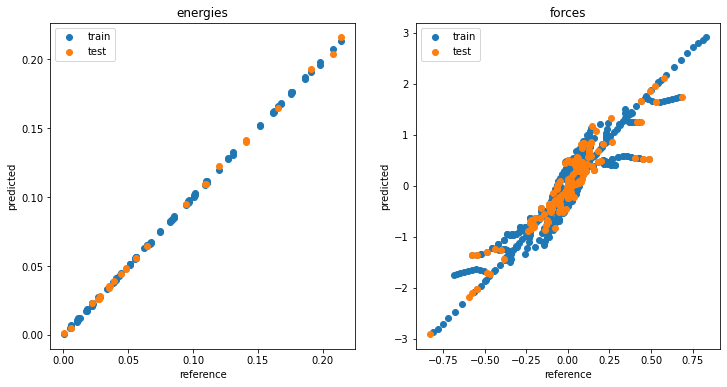

In [124]:
X = train_representation.block().values
y = train_energy.block().values

regularizer = 1e-6

weights = np.linalg.solve(X.T @ X + regularizer * np.eye(X.shape[1]), X.T @ y)

parity_plot(weights, train_energy, train_representation, test_energy, test_representation)

### Training energies and all forces

We can improve the prediction on forces by including this data in the training set:

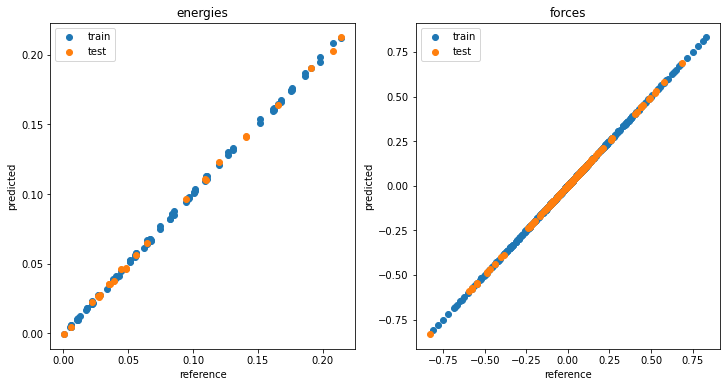

In [118]:
X = train_representation.block().values
X_grad = train_representation.block().gradient("positions").data

y = train_energy.block().values
y_grad = train_energy.block().gradient("positions").data

X = np.vstack([X, X_grad.reshape(-1, X.shape[-1])])
y = np.vstack([y, y_grad.reshape(-1, y.shape[-1])])

regularizer = 1e-6

weights = np.linalg.solve(X.T @ X + regularizer * np.eye(X.shape[1]), X.T @ y)

parity_plot(weights, train_energy, train_representation, test_energy, test_representation)

Unfortunately, including all the forces on all the atoms increases the cost of
training a model quite a lot. Both the computational cost (CPU time) and memory
cost increase significantly. In this tutorial we are fine since we are working
with a very small dataset.

Let's compare training only on energies and training on energies and all forces:

In [119]:
%%timeit

# Training on energies only

X = train_representation.block().values
y = train_energy.block().values

regularizer = 1e-6

weights = np.linalg.solve(X.T @ X + regularizer * np.eye(X.shape[1]), X.T @ y)

1.11 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [120]:
%%timeit

# Training on forces and energies

X = train_representation.block().values
X_grad = train_representation.block().gradient("positions").data

y = train_energy.block().values
y_grad = train_energy.block().gradient("positions").data

X = np.vstack([X, X_grad.reshape(-1, X.shape[-1])])
y = np.vstack([y, y_grad.reshape(-1, y.shape[-1])])

regularizer = 1e-6

weights = np.linalg.solve(X.T @ X + regularizer * np.eye(X.shape[1]), X.T @ y)

2.58 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Training on energy and a subset of the forces

Equistore allows us to easily incorporate only a subset of the forces in our
model, still getting much better forces prediction, while reducing the
computational cost of training the model!

For example, let's use only the forces acting on the first hydrogen atom, for
the first 40 frames.

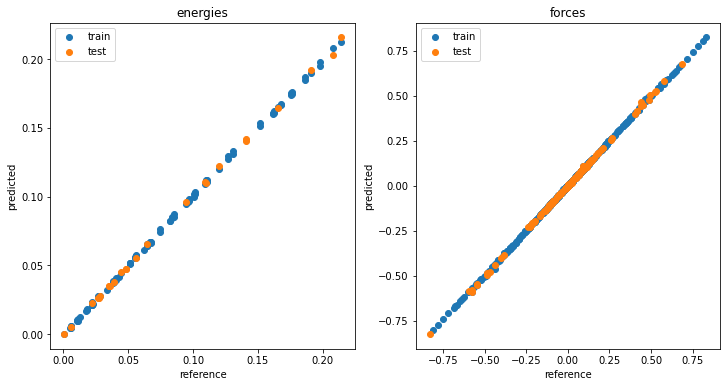

In [125]:
X = train_representation.block().values
gradient = train_representation.block().gradient("positions")
# select the right representation entries
mask = np.logical_and(gradient.samples["atom"] == 1, gradient.samples["structure"] < 40)
X_grad = gradient.data[mask]

y = train_energy.block().values
gradient = train_energy.block().gradient("positions")
# select the right property entries
mask = np.logical_and(gradient.samples["atom"] == 1, gradient.samples["structure"] < 40)
y_grad = gradient.data[mask]

X = np.vstack([X, X_grad.reshape(-1, X.shape[-1])])
y = np.vstack([y, y_grad.reshape(-1, y.shape[-1])])

regularizer = 1e-6

weights = np.linalg.solve(X.T @ X + regularizer * np.eye(X.shape[1]), X.T @ y)

parity_plot(weights, train_energy, train_representation, test_energy, test_representation)

This model should be faster and require less memory to train!

In [123]:
%%timeit

X = train_representation.block().values
gradient = train_representation.block().gradient("positions")
# select the right representation rows
mask = np.logical_and(gradient.samples["atom"] == 1, gradient.samples["structure"] < 40)
X_grad = gradient.data[mask]

y = train_energy.block().values
gradient = train_energy.block().gradient("positions")
# select the right property rows
mask = np.logical_and(gradient.samples["atom"] == 1, gradient.samples["structure"] < 40)
y_grad = gradient.data[mask]

X = np.vstack([X, X_grad.reshape(-1, X.shape[-1])])
y = np.vstack([y, y_grad.reshape(-1, y.shape[-1])])

regularizer = 1e-6

weights = np.linalg.solve(X.T @ X + regularizer * np.eye(X.shape[1]), X.T @ y)

1.61 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
